In [8]:
# Import Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.cloud import storage
from pathlib import Path
from PIL import Image
import cv2

In [9]:
# Install required library
!pip install -q google-cloud-storage

In [10]:
# Authenticate with GCP
from google.cloud import storage

# Set the GCS bucket and key file details
GCS_BUCKET = "yummy-secret-sauce"
GCS_KEY_PATH = "hairmatch-9da37740d8fa.json"
LOCAL_KEY_PATH = "/tmp/hairmatch-9da37740d8fa.json"

In [11]:
# Download the service account key from GCS
def download_key_from_gcs(bucket_name, blob_name, destination_path):
    """Download the service account key from a GCS bucket."""
    client = storage.Client()  # Use default credentials
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(destination_path)
    print(f"Downloaded service account key to {destination_path}")

download_key_from_gcs(GCS_BUCKET, GCS_KEY_PATH, LOCAL_KEY_PATH)

Downloaded service account key to /tmp/hairmatch-9da37740d8fa.json


In [12]:
# Set the environment variable to use the key for GCP services
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = LOCAL_KEY_PATH
print(f"GOOGLE_APPLICATION_CREDENTIALS set to {LOCAL_KEY_PATH}")

# Import GCS library
from google.cloud import storage

# Set dataset GCS paths
DATASET_BUCKET = "dataset-hairmatch"
MALE_DATASET_PATH = "male/"
LOCAL_MALE_PATH = "/content/dataset/male"

# Use the downloaded path for training and testing
TRAIN_DIR = os.path.join(LOCAL_MALE_PATH, "training_set")
TEST_DIR = os.path.join(LOCAL_MALE_PATH, "testing_set")

# Load the Pretrained Model from GCS
REFERENCE_BUCKET = "reference_models"
GCS_MODEL_PATH = "rcmalli_vggface_tf_notop_vgg16.h5"
PRETRAINED_MODEL_PATH = "/content/rcmalli_vggface_tf_notop_vgg16.h5"

SAVE_MODEL_PATH = "gs://dataset-hairmatch/models/v2_final_male_face_shape_classifier.h5"
SAVE_TFLITE_PATH = "gs://dataset-hairmatch/models/v2_final_male_face_shape_classifier.tflite"

GOOGLE_APPLICATION_CREDENTIALS set to /tmp/hairmatch-9da37740d8fa.json


In [13]:
# Helper function to download files from GCS
def download_files_from_gcs(bucket_name, source_path, destination_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=source_path)
    for blob in blobs:
        if not blob.name.endswith('/'):  # Skip directories
            # Recreate subfolder structure from GCS
            relative_path = blob.name.replace(source_path, "")
            local_file_path = os.path.join(destination_path, relative_path)

            # Ensure the directory exists locally
            os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

            # Download the file
            blob.download_to_filename(local_file_path)
            print(f"Downloaded {blob.name} to {local_file_path}")

# Download male dataset from GCS
download_files_from_gcs(DATASET_BUCKET, MALE_DATASET_PATH, LOCAL_MALE_PATH)

Downloaded male/testing_set/men_oval/ovale t1.jpg to /content/dataset/male/testing_set/men_oval/ovale t1.jpg
Downloaded male/testing_set/men_oval/ovale t10.jpg to /content/dataset/male/testing_set/men_oval/ovale t10.jpg
Downloaded male/testing_set/men_oval/ovale t100.jpg to /content/dataset/male/testing_set/men_oval/ovale t100.jpg
Downloaded male/testing_set/men_oval/ovale t101.jpg to /content/dataset/male/testing_set/men_oval/ovale t101.jpg
Downloaded male/testing_set/men_oval/ovale t102.jpg to /content/dataset/male/testing_set/men_oval/ovale t102.jpg
Downloaded male/testing_set/men_oval/ovale t103.jpg to /content/dataset/male/testing_set/men_oval/ovale t103.jpg
Downloaded male/testing_set/men_oval/ovale t104.jpg to /content/dataset/male/testing_set/men_oval/ovale t104.jpg
Downloaded male/testing_set/men_oval/ovale t105.jpg to /content/dataset/male/testing_set/men_oval/ovale t105.jpg
Downloaded male/testing_set/men_oval/ovale t106.jpg to /content/dataset/male/testing_set/men_oval/oval

In [ ]:
# Download male dataset from GCS
download_files_from_gcs(GCS_BUCKET, MALE_DATASET_PATH, LOCAL_MALE_PATH)

Authenticated client: <google.cloud.storage.client.Client object at 0x7f97bd78f4f0>
Accessing bucket: reference_models
Listing blobs with prefix: male/


In [14]:
# Download the model from GCS
def download_model(bucket_name, blob_name, destination_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(destination_path)
    print(f"Model downloaded to {destination_path}")

download_model(REFERENCE_BUCKET, GCS_MODEL_PATH, PRETRAINED_MODEL_PATH)

Model downloaded to /content/rcmalli_vggface_tf_notop_vgg16.h5


In [15]:
# early_stopping = EarlyStopping(
#     monitor='val_loss',   # Monitor validation loss
#     patience=5,           # Stop training after 5 epochs with no improvement
#     restore_best_weights=True  # Restore the best model weights
# )

In [20]:
def create_face_shape_classifier(weights_path, input_shape=(224, 224, 3)):
    # Load the VGG16 base model without the top layers
    base_model = tf.keras.applications.VGG16(
        include_top=False,  # Exclude the fully connected layers
        weights=None,  # Initialize without weights
        input_shape=input_shape
    )

    # Load the pretrained weights
    base_model.load_weights(weights_path)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add Custom Classification Head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(4, activation='softmax')(x)  # 4 classes for face shapes

    # Final Model
    model = models.Model(inputs=base_model.input, outputs=x)
    return model

# Create the model with the pretrained weights
face_shape_model = create_face_shape_classifier(PRETRAINED_MODEL_PATH)

# Compile the Model
face_shape_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
# Data augmentation pipeline using ImageDataGenerator
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # Split for training and validation
)

# Prepare training and validation data generators
train_generator = data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

validation_generator = data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

Found 952 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [22]:
face_shape_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,320,644 (62.26 MB)

 Trainable params: 1,605,956 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# Train the Model
history = face_shape_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    # callbacks=[early_stopping]  # Include the EarlyStopping callback
)

# Save the Model
face_shape_model.save(SAVE_MODEL_PATH)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 448ms/step - accuracy: 0.8546 - loss: 0.3965 - val_accuracy: 0.4808 - val_loss: 1.7003
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step - accuracy: 0.8345 - loss: 0.4320 - val_accuracy: 0.4808 - val_loss: 1.6430
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step - accuracy: 0.8531 - loss: 0.4100 - val_accuracy: 0.4135 - val_loss: 1.9247
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 375ms/step - accuracy: 0.8699 - loss: 0.3756 - val_accuracy: 0.4904 - val_loss: 1.7810
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.8348 - loss: 0.3867 - val_accuracy: 0.5192 - val_loss: 1.6707
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.8649 - loss: 0.3583 - val_accuracy: 0.5096 - val_loss: 1.5944
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.8620 - loss: 0.3799 - val_accuracy: 0.5385 - val_loss: 1.7711
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 374ms/step - accuracy: 0.8420 - loss: 0.4069 - val_accu

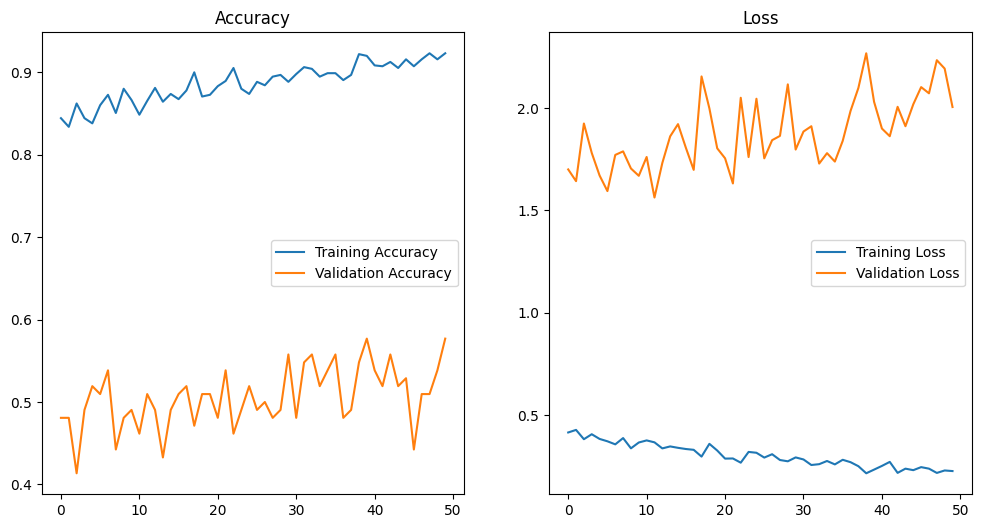

In [25]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training_history(history)

In [26]:
# Evaluate the Model
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_acc = face_shape_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

Found 384 images belonging to 4 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5318 - loss: 1.9014
Test Accuracy: 0.52, Test Loss: 1.85


In [27]:
from google.colab import files
from tensorflow.keras.utils import img_to_array, load_img

In [32]:
def predict_image(image_path, model, class_mapping, target_size=(224, 224)):
    """
    Predict the class of an uploaded image.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): Trained model to use for prediction.
    - class_mapping (dict): Mapping from class indices to class names.
    - target_size (tuple): Target size to resize the image.

    Returns:
    - str: Predicted class name.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image) / 255.0  # Normalize to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Predict the class
    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions[0])  # Get the index of the highest probability

    # Return the class name
    return class_mapping[predicted_index]

In [34]:
# Define class mapping
classes = {
    0: "Oval",
    1: "Rectangular",
    2: "Round",
    3: "Square"
}

# Upload an image and predict the class
uploaded = files.upload()  # Upload an image
for file_name in uploaded.keys():
    predicted_class = predict_image(file_name, face_shape_model, classes)
    print(f"Predicted class for '{file_name}': {predicted_class}")

Saving 0cd545542163567d5735afb2d2b21ec5.jpg to 0cd545542163567d5735afb2d2b21ec5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class for '0cd545542163567d5735afb2d2b21ec5.jpg': Square
